In [73]:
import sys
sys.path.append("module/") #add path for import
import matplotlib.pyplot as plt
import tigress_read
#reload for testing. Can be deleted later.
from importlib import reload
reload(tigress_read) 

<module 'tigress_read' from 'module/tigress_read.py'>

Read the meta data of the simulation model (See Table 2 in [Gong, Ostriker Kim and Kim (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/abbdab/meta)).   
The example below loads the data for model "R4-Z1", including both the CO (1-0) and CO (2-1) lines.

In [74]:
dir_master = "/projects/EOSTRIKE/COinTIGRESS/" #master directory of where the data is stored
#a list of index of lines that the program reads. Choose amoung {[1], [2], [1,2]}
#1 correspond to the CO (1-0) line and 2 the CO (2-1) line
lines = [1, 2] 
R4_Z1 = tigress_read.load("R4-Z1", lines, dir_master)

Each set of models contains a series of time snapshots from the MHD simulation.  
Below are all the time snapshots (in Myr) available in model "R4-Z1".

In [75]:
print("All time snapshots in Myr: ", R4_Z1.time_snapshots)

All time snapshots in Myr:  [ 50  60  70  80  90 100 110 120 130 140 150]


Now I read the data from the snapshot at 90 Myr.    
This corrrespond to the same snapshot in the middle column of Figure 2 in [Gong, Ostriker Kim and Kim (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/abbdab/meta).  
Because the data files are large, it can take a while to load.

In [76]:
ds = R4_Z1.get_data(90)

First, we inspect the data from the MHD simulation by the code Athena++.  
Because I use the python package [YT](https://yt-project.org/) to read the outputs from the MHD simulation, the data stored in the YT format. This means that all fields (such as density, velocity, H2 and CO abundances) directly from Athena++ has *unit* atached. 

I will show you how to access these fields and convert them into numpy arrays later. But first, you can print out the information of all the fields available using the code below (I commented it because the output is too long).

In [78]:
#print(ds.data_athena.field_info)

Let's start with an example reading the density field (the name of the field is simply "density").

In [79]:
density = ds.grid["density"]
print("The dimensions of the 3D density field: Nx={:d}, Ny={:d}, Nz={:d}".format(
       density.shape[0], density.shape[1], density.shape[2]))
print("The first 3 elements of the density field (along the z axis): ", density[0, 0, :3])
print("Check the type of the variable: ", type(density))

The dimensions of the 3D density field: Nx=256, Ny=256, Nz=512
The first 3 elements of the density field (along the z axis):  [0.00175314 0.00178339 0.00192668] code_mass/code_length**3
Check the type of the variable:  <class 'yt.units.yt_array.YTArray'>


You can see that there is a *unit* "code_mass/code_length**3" attached to the density field, which has the type of a YT array. Of course, you want to convert it to a sensible physical unit, which you can do by:

In [80]:
print("The first 3 elements of the density field in physical units: ", 
      density[0, 0, :3].in_units("g/cm**3"))

The first 3 elements of the density field in physical units:  [4.18752170e-27 4.25978829e-27 4.60205491e-27] g/cm**3


However, what you *really* want to do is to convert them into numpy arrays. You can do it with:

In [81]:
density_np = density.in_units("g/cm**3").value
print("Check the type of the variable: ", type(density_np))
print("The first 3 elements of the density field in physical units of g/cm**3, converted to numpy array: ", 
      density_np[0, 0, :3])

Check the type of the variable:  <class 'numpy.ndarray'>
The first 3 elements of the density field in physical units of g/cm**3, converted to numpy array:  [4.18752170e-27 4.25978829e-27 4.60205491e-27]


**Wola!**

Below are more examples (I print the maximum value of the 3D array for demonstration purposes):

In [82]:
print("Maximum number density of hydrogen atoms, in cm**-3: ", ds.grid["nH"].in_units("cm**-3").value.max())
print("Maximum abundance of CO relative to hydrogen: ", ds.grid["CO"].value.max())
print("Maximum abundance of H2 relative to hydrogen (NOTE 0.5 is fully molecular!): ", ds.grid["H2"].value.max())
print("Maximum velocity along the line of sight in km/s: ", ds.grid["velocity_z"].in_units("km/s").value.max())
print("Maximum gas temperature in K: ", ds.grid["temperature_chem"].in_units("K").value.max())

Maximum number density of hydrogen atoms, in cm**-3:  32383.88867184271
Maximum abundance of CO relative to hydrogen:  0.0001581618853379041
Maximum abundance of H2 relative to hydrogen (NOTE 0.5 is fully molecular!):  0.4999980330467224
Maximum velocity along the line of sight in km/s:  1247.6231689453125
Maximum gas temperature in K:  73505902.79440613


A short note:  
* The abundances of other chemical species (such as C, C+, HCO+ etc) in [Gong, Ostriker and Wolfire (2017)](http://adsabs.harvard.edu/abs/2017ApJ...843...38G) can also be accessed similar to CO and H2.
* The field "temperature_chem" is the equalibrium temperature from chemistry calculations. This is what is used for the synthetic observations as well. Another temperature field "temperature_init" is NOT used here - it is the initial temperature from the simulations without chemistry. 

In addition to the 3D simulation fields, I also calculated some 2D column density/surface density fields along the line of sight:

In [83]:
print("Maximum column density of hydrogen atoms, in cm**-2: ", ds.NH.in_units("cm**-2").value.max())
print("Maximum column density of H2 molecules, in cm**-2: ", ds.NH2.in_units("cm**-2").value.max())
print("Maximum column density of CO molecules, in cm**-2: ", ds.NCO.in_units("cm**-2").value.max())
print("Maximum gas surface density (including Helium and metals), in Msun/pc**2: ",
      ds.Sigma_tot.in_units("Msun/pc**2").value.max())

Maximum column density of hydrogen atoms, in cm**-2:  3.331814021285753e+23
Maximum column density of H2 molecules, in cm**-2:  1.6503760794419015e+23
Maximum column density of CO molecules, in cm**-2:  5.0843685405027795e+19
Maximum gas surface density (including Helium and metals), in Msun/pc**2:  3810.7967433499957


Now you have learned how to access the information from the numerical simulations, I will demonstrate how to read in the PPV cubes of the synthetic CO observations.    
You can access the data from the CO lines you specified:

In [84]:
print("'ds.radmc[1]' contains all the data for the CO (1-0) line. The line center wavelength in cm is: ",
      ds.radmc[1].img.lam0_cm)
print("'ds.radmc[2]' contains all the data for the CO (2-1) line. The line center wavelength in cm is: ",
      ds.radmc[2].img.lam0_cm)

'ds.radmc[1]' contains all the data for the CO (1-0) line. The line center wavelength in cm is:  0.260075763346
'ds.radmc[2]' contains all the data for the CO (2-1) line. The line center wavelength in cm is:  0.13004036558


Let's use the example for the CO (1-0) line.

First, the synthetic observation tool [RADMC](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/) makes the PPV cubes by producing the image at a series of wavelengths. This is slightly different from observation: in observation, the intensitiy is recorded in each **velocity channel** (e.g. between -0.5 and 0.5 km/s), but in RADMC, the image is created at **each velocity** (e.g. at 0 km/s). This can be understood approximately as the velocity at the center of the channel.

Also, because I have my won python script to read the RADMC outputs, the outputs are already numpy arrays **without units** attached. I used the standard unit if K for brightness temperature, and km/s for velocity.

In [85]:
#print("The velocities in the PPV cubes are (in km/s)", ds.radmc[1].img.vel_kms)
print("The velocity resolution and range in the PPV cubes are (in km/s):", 
      ds.radmc[1].img.vel_kms[1] - ds.radmc[1].img.vel_kms[0],
      [ds.radmc[1].img.vel_kms[0], ds.radmc[1].img.vel_kms[-1]])
print("The 2D image of Antena temperature at velocity ", ds.radmc[1].img.vel_kms[40], 
      "is (in Kelvin): \n", ds.radmc[1].img.image_TA[40])

The velocity resolution and range in the PPV cubes are (in km/s): 0.506329113986439 [-19.999999458053686, 20.00000054187467]
The 2D image of Antena temperature at velocity  0.25316509882433996 is (in Kelvin): 
 [[1.56419400e-11 2.95587284e-10 5.02718648e-09 ... 3.61113626e-14
  4.97046878e-12 2.10467768e-11]
 [7.78878728e-11 4.16207093e-09 2.79170105e-08 ... 2.37572812e-12
  8.34689261e-11 1.37468157e-10]
 [3.39143091e-11 7.96720147e-10 3.34570411e-08 ... 2.20124734e-11
  9.40209324e-10 1.00541081e-09]
 ...
 [1.22408019e-18 1.09068558e-18 3.93372660e-19 ... 1.00088321e-17
  7.71641119e-18 5.11601901e-18]
 [6.21246463e-18 2.75430187e-18 2.40247452e-19 ... 9.74656075e-18
  4.25778451e-17 8.74205295e-18]
 [1.46096931e-17 3.44004044e-18 1.55400005e-19 ... 4.50683220e-17
  6.51422858e-15 1.16569181e-16]]


I wrote a helper function to plot the Antena temperature image at a given veloicty:

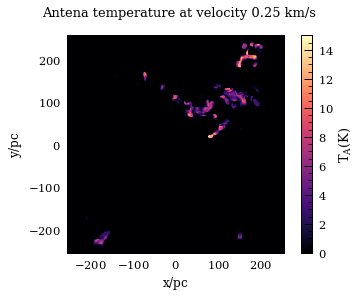

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111)
ds.radmc[1].img.plotimage(ax, ilam=40)
fig.suptitle("Antena temperature at velocity {:.2f} km/s".format(ds.radmc[1].img.vel_kms[40]));

For your convinence, I calculated some useful 2D quantities along the line of sight (defined similarly to the quantities of $W_\mathrm{CO}$, $T_\mathrm{peak}$, $\sigma_\mathrm{v}$ and $X_\mathrm{CO,20}$ in [Gong, Ostriker Kim and Kim (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/abbdab/meta)):

In [101]:
print("Maximum CO brightness in km/s: ", ds.radmc[1].WCO.max())
print("Maximum peak brightness temperature in K: ", ds.radmc[1].Tpeak.max())
print("Maximum velocity dispersion in km/s: ", ds.radmc[1].sigmav.max())
print("Average X_{CO,20} in CO-bright (W_CO > 0.75 km/s regions): ", 
      (ds.radmc[1].XCO_20[ds.radmc[1].WCO>0.75]).mean())

Maximum CO brightness in km/s:  223.46698819386637
Maximum peak brightness temperature in K:  14.994620500294745
Maximum velocity dispersion in km/s:  18.83497299310881
Average X_{CO,20} in CO-bright (W_CO > 0.75 km/s regions):  2.9540399541344593


Finally, if you'd rather use **FITS files**, I even have a function to output the PPV cubes into FITS files!

The commands below will save the CO (1-0) line PPV cube into a FITS file. Give it a try!

In [102]:
#ds.radmc[1].img.write_fits(fn_fits="image.fits")

This is the end. Let me know if you have any questions :)   
I'm looking forward to hearing about what you find in these data!  
-- Munan

ps. You may also check out the notebook make_fig2.ipynb. It reproduces Figure 2 in [Gong, Ostriker Kim and Kim (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/abbdab/meta).